In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import lightgbm as lgb

In [141]:
path = '/Users/kimtaehyeong/가스데이콘/235830_가스공급량 수요예측 모델개발_data/한국가스공사_시간별 공급량_20181231.csv'

In [142]:
total = pd.read_csv(path, encoding='cp949')

In [143]:
total.head(5)

,연월일,시간,구분,공급량
0,2013-01-01,1,A,2497.129
1,2013-01-01,2,A,2363.265
2,2013-01-01,3,A,2258.505
3,2013-01-01,4,A,2243.969
4,2013-01-01,5,A,2344.105


In [144]:
total.tail(5)

,연월일,시간,구분,공급량
368083,2018-12-31,20,H,681.033
368084,2018-12-31,21,H,669.961
368085,2018-12-31,22,H,657.941
368086,2018-12-31,23,H,610.953
368087,2018-12-31,24,H,560.896


2013년부터 2018년까지의 시간별 공급량 자료로 연/월/일/시간 단위로 구분하여 제공하고 있습니다.
'구분'은 공급사이지만 영업 비밀에 해당하여 비식별화 처리된 데이터이고, 
'공급량'은 영업비밀에 해당하여 원데이터와 유사한 패턴을 갖도록 처리된 데이터입니다.

In [145]:
# 구분이 어떤 유형인지 파악
total['구분'].unique()

array(['A', 'B', 'C', 'D', 'E', 'G', 'H'], dtype=object)

In [146]:
# 구분 a,b,c,d,e,g,h를 의미없는 숫자로 바꿔주는것이 좋다.

d_map = {}
for i, d in enumerate(total['구분'].unique()):
    d_map[d] = i
total['구분'] = total['구분'].map(d_map)

In [147]:
d_map

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'G': 5, 'H': 6}

In [148]:
total.head(5)


,연월일,시간,구분,공급량
0,2013-01-01,1,0,2497.129
1,2013-01-01,2,0,2363.265
2,2013-01-01,3,0,2258.505
3,2013-01-01,4,0,2243.969
4,2013-01-01,5,0,2344.105


In [149]:
# 연월일을 - 빼주자.
total['연월일'] = pd.to_datetime(total['연월일'])

In [150]:
total['year'] = total['연월일'].dt.year
total['month'] = total['연월일'].dt.month
total['day'] = total['연월일'].dt.day
total['weekday'] = total['연월일'].dt.weekday

In [151]:
train_years = [2013,2014,2015,2016,2017]
val_years = [2018]

In [152]:
train = total[total['year'].isin(train_years)]
val = total[total['year'].isin(val_years)]

In [153]:
features = ['구분','month','day','weekday','시간']
train_x = train[features]
train_y = train['공급량']

val_x = val[features]
val_y = val['공급량']

## 학습

## lightgbm

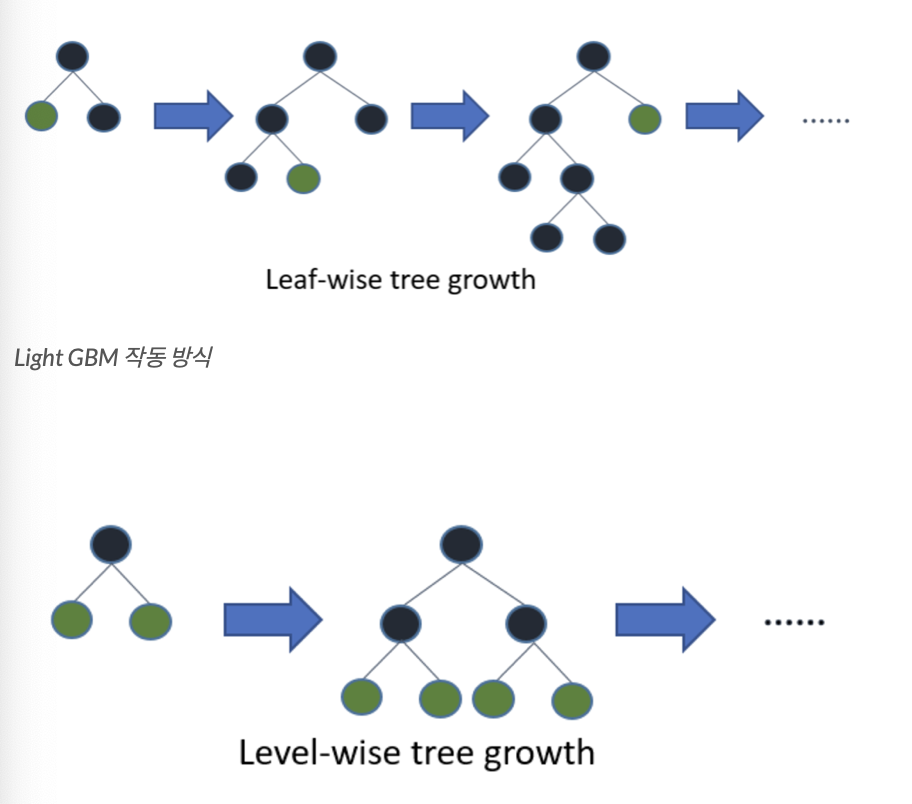

In [154]:
d_train = lgb.Dataset(train_x, train_y)
d_val = lgb.Dataset(val_x, val_y)

params = {
    'learning_rate': 0.003,           #추가한거
    'boosting_type': 'gbdt',
    'num_leaves' : 40,
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

model = lgb.train(params, d_train,500,d_val,verbose_eval=20, early_stopping_rounds=20)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 306768, number of used features: 5
[LightGBM] [Info] Start training from score 934.864036
Training until validation scores don't improve for 20 rounds
[20]	valid_0's l1: 719.306
[40]	valid_0's l1: 683.596
[60]	valid_0's l1: 650.196
[80]	valid_0's l1: 618.97
[100]	valid_0's l1: 589.759
[120]	valid_0's l1: 562.464
[140]	valid_0's l1: 536.995
[160]	valid_0's l1: 513.197
[180]	valid_0's l1: 490.92
[200]	valid_0's l1: 470.098
[220]	valid_0's l1: 450.677
[240]	valid_0's l1: 432.64
[260]	valid_0's l1: 415.847
[280]	valid_0's l1: 400.169
[300]	valid_0's l1: 385.439
[320]	valid_0's l1: 371.463
[340]	valid_0's l1: 358.296
[360]	valid_0's l1: 346.026
[380]	valid_0's l1: 334.751
[400]

In [155]:
test = pd.read_csv('/Users/kimtaehyeong/가스데이콘/235830_가스공급량 수요예측 모델개발_data/test.csv')
submission = pd.read_csv('/Users/kimtaehyeong/가스데이콘/235830_가스공급량 수요예측 모델개발_data/sample_submission.csv')

In [156]:
test.head()

,일자|시간|구분
0,2019-01-01 01 A
1,2019-01-01 02 A
2,2019-01-01 03 A
3,2019-01-01 04 A
4,2019-01-01 05 A


In [157]:
submission.head()

,일자|시간|구분,공급량
0,2019-01-01 01 A,0
1,2019-01-01 02 A,0
2,2019-01-01 03 A,0
3,2019-01-01 04 A,0
4,2019-01-01 05 A,0


In [158]:
test['일자'] = test['일자|시간|구분'].str.split(' ').str[0]
test['시간'] = test['일자|시간|구분'].str.split(' ').str[1].astype(int)
test['구분'] = test['일자|시간|구분'].str.split(' ').str[2]

In [159]:
test

,일자|시간|구분,일자,시간,구분
0,2019-01-01 01 A,2019-01-01,1,A
1,2019-01-01 02 A,2019-01-01,2,A
2,2019-01-01 03 A,2019-01-01,3,A
3,2019-01-01 04 A,2019-01-01,4,A
4,2019-01-01 05 A,2019-01-01,5,A
...,...,...,...,...
15115,2019-03-31 20 H,2019-03-31,20,H
15116,2019-03-31 21 H,2019-03-31,21,H
15117,2019-03-31 22 H,2019-03-31,22,H
15118,2019-03-31 23 H,2019-03-31,23,H


In [160]:
test['일자'] = pd.to_datetime(test['일자'])
test['year'] = test['일자'].dt.year
test['month'] = test['일자'].dt.month
test['day'] = test['일자'].dt.day
test['weekday'] = test['일자'].dt.weekday

In [161]:
test['구분'] = test['구분'].map(d_map)

In [162]:
test_x = test[features]

In [163]:
test_x

,구분,month,day,weekday,시간
0,0,1,1,1,1
1,0,1,1,1,2
2,0,1,1,1,3
3,0,1,1,1,4
4,0,1,1,1,5
...,...,...,...,...,...
15115,6,3,31,6,20
15116,6,3,31,6,21
15117,6,3,31,6,22
15118,6,3,31,6,23


In [164]:
preds = model.predict(test_x)

In [165]:
submission['공급량'] = preds

In [166]:
submission.to_csv('baseline2.csv', index=False)